In [1]:
!python -V

Python 3.9.17


In [17]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import pandas as pd
import numpy as np

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [10]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


2024/12/25 17:51:38 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/luisvaras/code/zoomcamp/mlops-zoomcamp/03-training/experiment_tracking/mlruns/1', creation_time=1735159898745, experiment_id='1', last_update_time=1735159898745, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [11]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df.lpep_dropoff_datetime - df.lpep_pickup_datetime

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <=60)]

cat = ['PULocationID', 'DOLocationID']
num = ['trip_distance']

df[cat] = df[cat].astype(str)

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

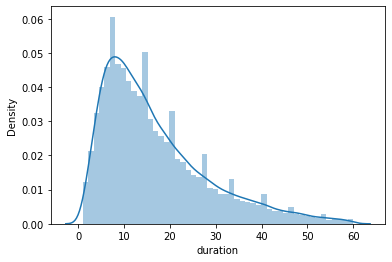

In [11]:
# df
sns.distplot(df.duration)

In [14]:
# convert DF to Dictionary
# df[cat + num].iloc[:10].to_dict(orient='records')
train_dicts = df[cat + num].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mse = mean_squared_error(y_train, y_pred) #, squared=False)
rmse = np.sqrt(mse)

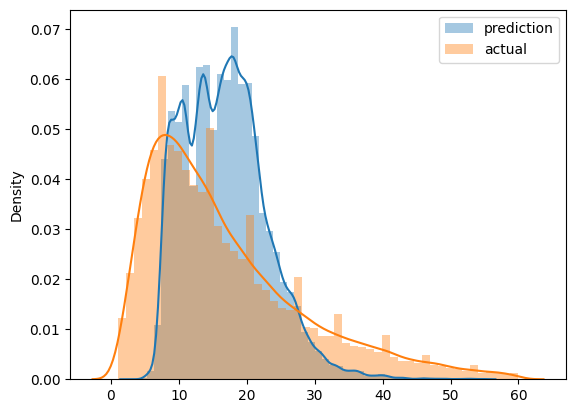

In [18]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')
plt.legend()

In [19]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <=60)]

    cat = ['PULocationID', 'DOLocationID']
    df[cat] = df[cat].astype(str)

    return df

In [20]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [21]:
len(df_train), len(df_val)

(73908, 61921)

In [22]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [23]:
cat = ['PU_DO'] #['PULocationID', 'DOLocationID']
num = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[cat + num].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[cat + num].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [28]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

#mean_squared_error(y_val, y_pred, squared=False)
mse = mean_squared_error(y_val, y_pred) #, squared=False)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse:.2f}')

RMSE: 7.76


In [29]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [53]:
with mlflow.start_run():

    mlflow.set_tag("developer", "luis")
    mlflow.log_param("train-data-path", './data/green_tripdata_2021-01.parquet')
    mlflow.log_param("val-data-path", './data/green_tripdata_2021-02.parquet')

    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    #mean_squared_error(y_val, y_pred, squared=False)
    mse = mean_squared_error(y_val, y_pred) #, squared=False)
    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path='models/lin_reg.bin', artifact_path='models_pickle')

In [34]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [36]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [37]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        mse = mean_squared_error(y_val, y_pred) #, squared=False)
        rmse = np.sqrt(mse)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [38]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()

)

[0]	validation-rmse:8.49781                           
[1]	validation-rmse:7.17193                           
[2]	validation-rmse:6.73345                           
[3]	validation-rmse:6.57592                           
[4]	validation-rmse:6.50861                           
[5]	validation-rmse:6.48066                           
[6]	validation-rmse:6.45617                           
[7]	validation-rmse:6.44290                           
[8]	validation-rmse:6.43776                           
[9]	validation-rmse:6.43271                           
[10]	validation-rmse:6.42896                          
[11]	validation-rmse:6.42452                          
[12]	validation-rmse:6.41868                          
[13]	validation-rmse:6.41488                          
[14]	validation-rmse:6.41052                          
[15]	validation-rmse:6.40751                          
[16]	validation-rmse:6.40484                          
[17]	validation-rmse:6.40347                          
[18]	valid

KeyboardInterrupt: 

In [39]:
params = {
    'learning_rate': 0.5007497542674484,
    'max_depth': 69,
    'min_child_weight': 1.593971756791148,
    'objective': 'reg:linear',
    'reg_alpha': 0.05449929909264596,
    'reg_lambda': 0.34077893742416615,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2024/12/25 21:10:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8bce676a00b042de963a6dd6ed448991', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:8.49781
[1]	validation-rmse:7.17193
[2]	validation-rmse:6.73345
[3]	validation-rmse:6.57592
[4]	validation-rmse:6.50861
[5]	validation-rmse:6.48066
[6]	validation-rmse:6.45617
[7]	validation-rmse:6.44290
[8]	validation-rmse:6.43776
[9]	validation-rmse:6.43271
[10]	validation-rmse:6.42896
[11]	validation-rmse:6.42452
[12]	validation-rmse:6.41868
[13]	validation-rmse:6.41488
[14]	validation-rmse:6.41052
[15]	validation-rmse:6.40751
[16]	validation-rmse:6.40484
[17]	validation-rmse:6.40347
[18]	validation-rmse:6.39845
[19]	validation-rmse:6.39603
[20]	validation-rmse:6.39398
[21]	validation-rmse:6.39171
[22]	validation-rmse:6.38840
[23]	validation-rmse:6.38623
[24]	validation-rmse:6.38325
[25]	validation-rmse:6.38065
[26]	validation-rmse:6.37983
[27]	validation-rmse:6.37647
[28]	validation-rmse:6.37435
[29]	validation-rmse:6.37246
[30]	validation-rmse:6.36992
[31]	validation-rmse:6.36800
[32]	validation-rmse:6.36687
[33]	validation-rmse:6.36443
[34]	validation-rmse:6.3

2024/12/25 21:19:35 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/12/25 21:19:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [43]:
mlflow.xgboost.autolog(disable=True)


In [45]:
with mlflow.start_run():

    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.5007497542674484,
        'max_depth': 69,
        'min_child_weight': 1.593971756791148,
        'objective': 'reg:linear',
        'reg_alpha': 0.05449929909264596,
        'reg_lambda': 0.34077893742416615,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)

    mse = mean_squared_error(y_val, y_pred) #, squared=False)
    rmse = np.sqrt(mse)
    mlflow.log_metric("rmse", rmse)


    with open('models/preprocessor.b', 'wb') as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path='preprocessor')
    mlflow.xgboost.log_model(booster, artifact_path='models_mlflow')

[0]	validation-rmse:8.49781
[1]	validation-rmse:7.17193
[2]	validation-rmse:6.73345
[3]	validation-rmse:6.57592
[4]	validation-rmse:6.50861
[5]	validation-rmse:6.48066
[6]	validation-rmse:6.45617
[7]	validation-rmse:6.44290
[8]	validation-rmse:6.43776
[9]	validation-rmse:6.43271
[10]	validation-rmse:6.42896
[11]	validation-rmse:6.42452
[12]	validation-rmse:6.41868
[13]	validation-rmse:6.41488
[14]	validation-rmse:6.41052
[15]	validation-rmse:6.40751
[16]	validation-rmse:6.40484
[17]	validation-rmse:6.40347
[18]	validation-rmse:6.39845
[19]	validation-rmse:6.39603
[20]	validation-rmse:6.39398
[21]	validation-rmse:6.39171
[22]	validation-rmse:6.38840
[23]	validation-rmse:6.38623
[24]	validation-rmse:6.38325
[25]	validation-rmse:6.38065
[26]	validation-rmse:6.37983
[27]	validation-rmse:6.37647
[28]	validation-rmse:6.37435
[29]	validation-rmse:6.37246
[30]	validation-rmse:6.36992
[31]	validation-rmse:6.36800
[32]	validation-rmse:6.36687
[33]	validation-rmse:6.36443
[34]	validation-rmse:6.3

2024/12/25 22:14:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [46]:
logged_model = 'runs:/b4e5d303ed394f9ebceb9db15ca3a4d2/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)


In [47]:
# Predict on a Pandas DataFrame.
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: b4e5d303ed394f9ebceb9db15ca3a4d2

In [48]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [50]:
xgboost_model.predict(valid)

In [51]:
y_pred = xgboost_model.predict(valid)

In [52]:
y_pred[:10]

array([14.055848 ,  6.5770626, 13.076859 , 24.574144 ,  9.397497 ,
       17.068619 , 10.59555  ,  7.685579 ,  8.997662 , 15.680276 ],
      dtype=float32)